In [1]:
# pull data from polygon
import datetime
import numpy as np
from scipy.signal import detrend
import requests

def pull_data(ticker, api_key):
    years = 1
    # Define the date range
    end_datetime = datetime.datetime(2024,8,1)
    start_datetime = end_datetime - datetime.timedelta(days = round(365*years))


    # Polygon API endpoint for aggregate bars
    url = f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/1/day/{start_datetime.date()}/{end_datetime.date()}?adjusted=true&apiKey={api_key}"
    
    # Fetch the data
    response = requests.get(url)
    data = response.json()

    if 'results' not in data:
        raise ValueError(f"Error fetching data: {data}")

    # Convert data to arrays
    times = np.array([entry['t'] for entry in data['results']])  # Timestamps
    close = np.array([entry['c'] for entry in data['results']])  # Closing prices

    # Detrend closing prices
    detrended_close = detrend(close)

    return times, close, detrended_close, data

# Example usage:
key = 'jjeryxeZXNkBhTEQF0SDj8uBBI_N1dBM'	
ticker = 'CL'
times,close,detrended,df= pull_data(ticker,key)
_,close2,detrended2,df2= pull_data('ES',key)


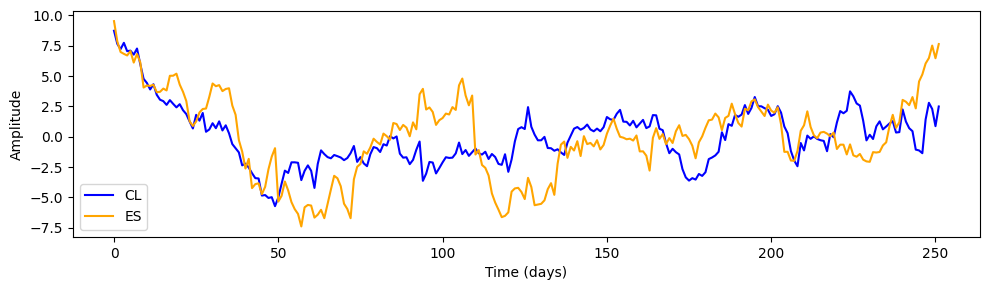

In [2]:
import matplotlib.pyplot as plt

# Create subplots
fig, axs = plt.subplots(1, 1, figsize=(10, 3), sharex=True)

# Plot detrended
axs.plot(detrended, label='CL', color='blue')
#axs.set_title('Detrended Signal')
axs.set_ylabel('Amplitude')
axs.legend()

# Plot detrended2
axs.plot(detrended2, label='ES', color='orange')
#axs[1].set_title('Detrended2 Signal')
axs.set_xlabel('Time (days)')
axs.set_ylabel('Amplitude')
axs.legend()

# Adjust layout
plt.tight_layout()
plt.show()

In [3]:
import numpy as np
from pycwt import wct
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import scipy.io.wavfile as wav
import fcwt
# Compute the wavelet coherence
def wavelet_coherence(signal1,signal2,highest,lowest,nfreqs,frame_rate):
    freqs, coeffs1 = fcwt.cwt(signal1,frame_rate,lowest,highest,nfreqs,nthreads = 4,)
    freqs, coeffs2 = fcwt.cwt(signal2,frame_rate,lowest,highest,nfreqs,nthreads = 4,)

    # Compute coherence
    S1 = np.abs(coeffs1) ** 2
    S2 = np.abs(coeffs2) ** 2
    S12 = coeffs1 * np.conj(coeffs2)
    
    # Smooth spectra and cross-spectrum
    def smooth(data, sigma=(2,2), mode='nearest'):
        #return data
        return gaussian_filter(data, sigma=sigma, mode=mode)

    S1_smoothed = smooth(S1)
    S2_smoothed = smooth(S2)
    S12_smoothed = smooth(np.abs(S12) ** 2)

    # Coherence calculation
    coherence = S12_smoothed / (((S1_smoothed) **2) * ((S2_smoothed)**2))
    coherence = S12_smoothed / (np.sqrt(S1_smoothed) * np.sqrt(S2_smoothed))
    #coherence = np.clip(coherence, 0.0, 1.0)  # Limit coherence to [0, 1]

    return coherence, freqs, [coeffs1,coeffs2], S12

lowest = 2 # days
highest = 100 # days

coherence, freqs, coeffs, S12 = wavelet_coherence(detrended, detrended2, 1/lowest, 1/highest, 100, 1)

In [4]:
def coherence_plot_with_arrows(coherence, freqs, S12,density = 20):
    extent = [0, coherence.shape[1], len(freqs), 0]

    # Normalize coherence for color map
    #coherence = np.clip(coherence, 0, 3)
    norm_coh = (coherence - coherence.min()) / (coherence.max() - coherence.min())

    # Phase angle and vectors
    phase = np.angle(S12)
    U = np.cos(phase)
    V = np.sin(phase)

    # Coordinate grid
    X, Y = np.meshgrid(np.arange(coherence.shape[1]), np.arange(coherence.shape[0]))

    # Mask: only take high-coherence regions
    mask = norm_coh > .4
    indices = np.argwhere(mask)

    # Subsample: take every nth index from the masked points
    subsample_rate = extent[1] // density  # Adjust this value to control the number of arrows
    subsampled_indices = indices[::subsample_rate]

    x_sub = [X[i, j] for i, j in subsampled_indices]
    y_sub = [Y[i, j] for i, j in subsampled_indices]
    u_sub = [U[i, j] for i, j in subsampled_indices]
    v_sub = [V[i, j] for i, j in subsampled_indices]

    y_values = np.logspace(np.log10(freqs[0]), np.log10(freqs[-1]), len(freqs))

    subsampled_indices = np.linspace(0, len(y_values) - 1, 20, dtype=int)
    subsampled_y_values = y_values[subsampled_indices]
    extent=[0, coherence.shape[1], len(freqs),0]

    # Plot coherence
    fig, ax = plt.subplots(figsize=(10, 6))
    im = ax.imshow(norm_coh, aspect='auto', extent=extent, cmap='Blues')
    ax.quiver(x_sub, y_sub, u_sub, v_sub, color='black', scale=20, headwidth=4
              , headlength=5, headaxislength=4)

    dt = 1 / 250


    # Axes labels and ticks
    ax.set_yticks(subsampled_indices)
    ax.set_yticklabels(subsampled_y_values.round(2))
    ax.set_xticks(np.linspace(0, coherence.shape[1], 5))
    ax.set_ylabel('Frequency (Per Year)', fontsize=14)
    ax.set_xlabel('Time (Days)', fontsize=14)
    #ax.set_title('Wavelet Coherence', fontsize=16)
    fig.colorbar(im, ax=ax)
    #ax.legend()

    return fig



In [5]:


# --- WAVELET COHERENCE FUNCTION ---
def wavelet_coherence(signal1, signal2, highest_freq, lowest_freq, nfreqs, sampling_rate):
    freqs, coeffs1 = fcwt.cwt(signal1, sampling_rate, lowest_freq, highest_freq, nfreqs, nthreads=4,scaling='log')
    _, coeffs2 = fcwt.cwt(signal2, sampling_rate, lowest_freq, highest_freq, nfreqs, nthreads=4,scaling='log')
    
    S1 = np.abs(coeffs1) ** 2
    S2 = np.abs(coeffs2) ** 2
    S12 = coeffs1 * np.conj(coeffs2)

    def smooth(data, sigma=(2, 2), mode='nearest'):
        return gaussian_filter(data, sigma=sigma, mode=mode)

    S1_smooth = smooth(S1)
    S2_smooth = smooth(S2)
    S12_smooth = smooth(np.abs(S12) ** 2)

    coherence = S12_smooth / (np.sqrt(S1_smooth) * np.sqrt(S2_smooth))
    return coherence, freqs

def coherence(coeffs1, coeffs2, freqs):
    S1 = np.abs(coeffs1) ** 2
    S2 = np.abs(coeffs2) ** 2
    S12 = coeffs1 * np.conj(coeffs2)

    def smooth(data, sigma=(2, 2), mode='nearest'):
        return gaussian_filter(data, sigma=sigma, mode=mode)

    S1_smooth = smooth(S1)
    S2_smooth = smooth(S2)
    S12_smooth = smooth(np.abs(S12) ** 2)

    coh = S12_smooth / (np.sqrt(S1_smooth) * np.sqrt(S2_smooth))
    return coh, freqs, S12


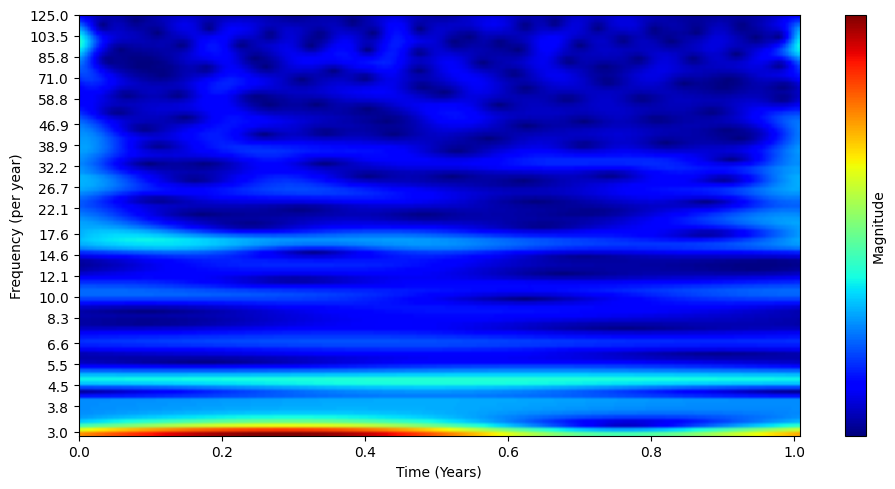

(array([[ 0.2989902 +2.5140744e-01j, -0.32710022-1.5235759e-01j,
          0.31906694+6.1083168e-02j, ...,  0.32064825-1.7722401e-01j,
         -0.2804513 +2.7102789e-01j,  0.20696945-3.5333264e-01j],
        [ 0.46573198+3.1406355e-01j, -0.48970735-1.4598298e-01j,
          0.4496246 -4.3808669e-04j, ...,  0.47892633-2.0337102e-01j,
         -0.433416  +3.5590035e-01j,  0.32828438-4.9524432e-01j],
        [ 0.68707454+3.3738011e-01j, -0.68603814-6.2801115e-02j,
          0.5737026 -1.5820104e-01j, ...,  0.63381505-1.4755407e-01j,
         -0.6183913 +3.7505633e-01j,  0.50012547-6.0495496e-01j],
        ...,
        [ 0.24043953-1.4563113e+00j,  0.36325532-1.4483606e+00j,
          0.48639137-1.4297855e+00j, ..., -0.53784233-1.2396890e+00j,
         -0.44083065-1.2967206e+00j, -0.3379246 -1.3459517e+00j],
        [ 0.82108724-1.9825106e+00j,  0.98103946-1.9304193e+00j,
          1.1379639 -1.8650913e+00j, ..., -0.29198986-1.9837263e+00j,
         -0.14090973-2.0206561e+00j,  0.01443976

In [6]:
def transform(signal1,frame_rate,highest,lowest):
    nfreqs = 100
    freqs, coeffs1 = fcwt.cwt(signal1,frame_rate,lowest,highest,nfreqs,nthreads = 4,scaling='log')

    return coeffs1,freqs

def transform_plot(signal,frame_rate,highest,lowest):


    coeffs1,freqs = transform(signal,frame_rate,highest,lowest)

    y_values = np.logspace(np.log10(freqs[0]), np.log10(freqs[-1]), len(freqs))
    subsampled_indices = np.linspace(0, len(y_values) - 1, 20, dtype=int)
    subsampled_y_values = y_values[subsampled_indices]
    extent=[0, len(signal)/frame_rate, len(freqs),0]
    plt.figure(figsize=(10, 5));
    plt.imshow(np.abs(coeffs1), aspect='auto', extent=extent, cmap='jet')
    plt.yticks(ticks=subsampled_indices, labels=[f"{y:.1f}" for y in subsampled_y_values])

    cbar = plt.colorbar()
    cbar.ax.set_ylabel('Magnitude')
    cbar.set_ticks([])  
    plt.xlabel('Time (Years)')
    plt.ylabel('Frequency (per year)')
    #plt.title('Wavelet Transform Magnitude')
    plt.tight_layout()
    plt.show()
    return coeffs1,freqs
transform_plot(detrended2,250,125,3)

In [7]:
def coherence_plot(coh,freqs,sampling_rate):
    y_values = np.logspace(np.log10(freqs[0]), np.log10(freqs[-1]), len(freqs))

    subsampled_indices = np.linspace(0, len(y_values) - 1, 20, dtype=int)
    subsampled_y_values = y_values[subsampled_indices]
    extent=[0, coh.shape[1]/sampling_rate, len(freqs),0]
    plt.figure(figsize=(10, 5));
    plt.imshow(coh, aspect='auto', extent=extent, cmap='Blues')
    plt.yticks(ticks=subsampled_indices, labels=[f"{y:.1f}" for y in subsampled_y_values])

    plt.colorbar(label='Coherence')
    plt.xlabel('Time (years)')
    plt.ylabel('Frequency (per year)')
    plt.title('Wavelet Coherence')
    plt.tight_layout()
    plt.show()

def workflow(sig1,sig2,bounds,phase = True):
    sampling_rate = 250 # Assuming days per year
    highest = bounds[0]
    lowest = bounds[1]
    t1,_ = transform(sig1, 250, highest, lowest)
    t2,freqs = transform(sig2, 250, highest, lowest)
    coh, _, S12 = coherence(t1, t2, freqs)
    if phase:
        coherence_plot_with_arrows(coh, freqs, S12)
    else:
        coherence_plot(coh, freqs, 250)
    return freqs,S12,coh


#sig1 = pull_data('TSLA', key)[2]  # Detrended signal for AAPL
#sig2 = pull_data('MSTR', key)[2]  # Detrended signal for AMZN
#bounds = (125, 8)  # Example bounds for the wavelet transform
#freqs,S12,coh = workflow(sig1,sig2,bounds)

In [8]:
import numpy as np

def generate_nonstationary_signal(duration, sampling_rate, freq_range):
    t = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)
    signal = np.zeros_like(t)

    # Embed frequencies within the specified range
    for freq in np.linspace(freq_range[0], freq_range[1], num=5):  # 5 frequencies
        amplitude = np.random.uniform(0.5, 1.5)  # Random amplitude
        phase = np.random.uniform(0, 2 * np.pi)  # Random phase
        modulation = np.exp(-0.5 * ((t - duration / 2) / (duration / 4))**2)  # Gaussian envelope
        signal += amplitude * modulation * np.sin(2 * np.pi * freq * t + phase)

    # Add random noise
    signal += 0.2 * np.random.randn(len(t))
    return t, signal

# Parameters
duration = 10  # seconds
sampling_rate = 250  # Hz
freq_range = (10, 100)  # Hz

In [ ]:
# filename: wavelet_dashboard.ipynb

import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt

# Your functions: transform, coherence, coherence_plot, coherence_plot_with_arrows, pull_data

def workflow(sig1, sig2, bounds, phase=True,density = 20):
    sampling_rate = 250  # days/year
    highest, lowest = bounds
    t1, _ = transform(sig1, sampling_rate, highest, lowest)
    t2, freqs = transform(sig2, sampling_rate, highest, lowest)
    coh, _, S12 = coherence(t1, t2, freqs)
    
    #fig = plt.figure(figsize=(10, 6));
    if phase:
        coherence_plot_with_arrows(coh, freqs, S12,density)
    else:
        coherence_plot(coh, freqs, sampling_rate)
    plt.show()

    return freqs, S12, coh

# --- Widgets ---
ticker1 = widgets.Text( description='Stock 1:')
ticker2 = widgets.Text( description='Stock 2:')
upper_bound = widgets.IntSlider(value=125, min=20, max=250, step=5, description='Max Period:')
lower_bound = widgets.IntSlider(value=8, min=2, max=50, step=1, description='Min Period:')
phase_toggle = widgets.Checkbox(value=True, description='Show Phase Arrows')
run_button = widgets.Button(description='Run Analysis')

import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

output = widgets.Output()

def on_run_clicked(b):
    with output:
        clear_output(wait=True)
        sig1 = pull_data(ticker1.value, key)[2]
        sig2 = pull_data(ticker2.value, key)[2]
        bounds = (upper_bound.value, lower_bound.value)
        workflow(sig1, sig2, bounds, phase=phase_toggle.value,density = 20)

run_button.on_click(on_run_clicked)

# Layout
ui = widgets.VBox([
    widgets.HBox([ticker1, ticker2]),
    upper_bound,
    lower_bound,
    phase_toggle,
    run_button,
    output
])

display(ui)


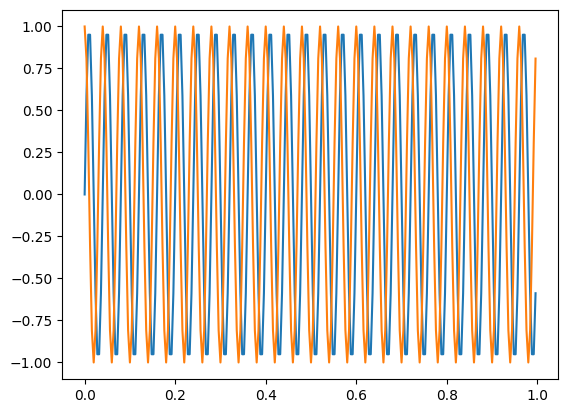

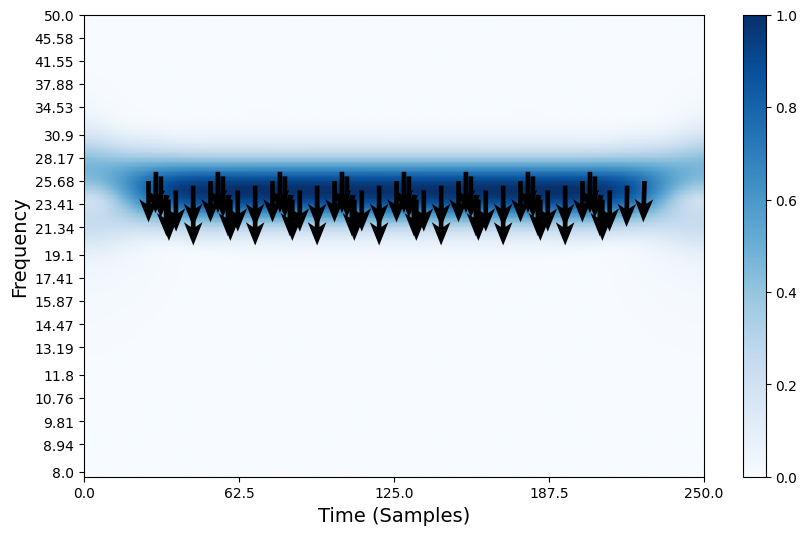

(array([50.000004 , 49.082977 , 48.18276  , 47.299057 , 46.431557 ,
        45.579975 , 44.744007 , 43.923378 , 43.11779  , 42.326984 ,
        41.550674 , 40.788612 , 40.04052  , 39.306152 , 38.58525  ,
        37.877575 , 37.182873 , 36.500916 , 35.831463 , 35.174294 ,
        34.52917  , 33.895885 , 33.27421  , 32.663944 , 32.06486  ,
        31.476776 , 30.899467 , 30.332754 , 29.776428 , 29.230314 ,
        28.694208 , 28.16794  , 27.651318 , 27.144178 , 26.646332 ,
        26.157625 , 25.677874 , 25.206926 , 24.744617 , 24.290783 ,
        23.845272 , 23.407936 , 22.978622 , 22.557177 , 22.143461 ,
        21.737339 , 21.338663 , 20.947296 , 20.563107 , 20.185968 ,
        19.815744 , 19.45231  , 19.095541 , 18.745317 , 18.401518 ,
        18.06402  , 17.732714 , 17.407486 , 17.088223 , 16.77481  ,
        16.46715  , 16.165133 , 15.868654 , 15.577611 , 15.291907 ,
        15.011442 , 14.736125 , 14.465855 , 14.200541 , 13.940097 ,
        13.684425 , 13.433443 , 13.187063 , 12.9

In [82]:
import numpy as np

# Parameters
sampling_rate = 250  # Hz
duration = 1  # seconds
frequency = 25  # Hz (example frequency for sine and cosine waves)

# Time array
t = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)

# Generate signals
sig1 = np.sin(2 * np.pi * frequency * t)  # Sine wave
sig2 = np.cos(2 * np.pi * frequency * t)  # Cosine wave


plt.plot(t,sig1)
plt.plot(t,sig2)
workflow(sig1, sig2, (50, 8), phase=True,density = 10)

In [95]:
display(ui)
